# Predicting the property crime rate in states using machine learning 

In this notebook, we will use the FBI's UCR (Uniform Crime Reporting) to create a time-series to perform a regression analysis on to see property crime rates in various states and forecast potential property crimes. 

## 1. Problem Definition 
Predict property crime rates by a state-by-state basis. 

## 2. Data

The data has been downloaded by the FBI's UCR crime explorer.
https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/explorer/crime/crime-trend

## 3. Evaluation
To evaluate our time series predictions, we will use multiple metrics:

1. RMSE (Root Mean Square Error)
   * Primary metric
   * Measures average prediction error in actual crime rate units
   * More weight to large errors
   * Interpretable: "On average, our predictions are off by X crimes per 100,000 population"

2. MAPE (Mean Absolute Percentage Error)
   * Shows error as a percentage
   * Useful for comparing accuracy across states with different crime rates
   * Easy to explain: "Our predictions are off by X% on average"

3. R² Score
   * Indicates how much of the variance in crime rates our model explains
   * Useful for model comparison and communication with stakeholders

## 4. Features

### 1. Clean data 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd 
import os
import glob 

In [10]:
def process_state_file(file_path):
    """
    Process individual state crime rate files with persistent type conversion
    """
    # Extract state name from filename
    state = os.path.basename(file_path).replace('_PropertyCrimeRate.csv', '')
    
    # Read the CSV
    df = pd.read_csv(file_path)
    
    # Get the state's crime rate series (first row)
    state_data = df.iloc[0]
    
    # Convert to long format with explicit type conversion
    data_long = pd.DataFrame({
        'date': pd.to_datetime(state_data.index[1:], format='%m-%Y'),
        'crime_rate': pd.to_numeric(state_data.values[1:], errors='coerce'),
        'state': state
    })
    
    # Force types immediately
    data_long = data_long.astype({
        'crime_rate': 'float64',
        'state': 'string'
    })
    
    print(f"Processed {state}")
    return data_long

In [11]:
def combine_state_files(data_directory):
    """
    Combine all state files with guaranteed type consistency
    """
    files = glob.glob(os.path.join(data_directory, '*_PropertyCrimeRate.csv'))
    
    all_states = []
    for file in files:
        state_df = process_state_file(file)
        # Verify types before appending
        assert state_df['crime_rate'].dtype == 'float64', f"Crime rate not float64 in {file}"
        assert state_df['state'].dtype == 'string', f"State not string in {file}"
        all_states.append(state_df)
    
    # Combine all states
    combined_df = pd.concat(all_states, ignore_index=True)
    
    # Force types again after concatenation
    combined_df = combined_df.astype({
        'crime_rate': 'float64',
        'state': 'string'
    })
    
    # Sort by state and date
    combined_df = combined_df.sort_values(['state', 'date'])
    
    return combined_df


In [12]:
def validate_combined_data(df):
    """
    Validate the combined dataset
    
    Parameters:
    df (pd.DataFrame): Combined state data
    
    Returns:
    dict: Validation statistics
    """
    stats = {
        'total_states': df['state'].nunique(),
        'date_range': (df['date'].min(), df['date'].max()),
        'missing_values': df.isnull().sum().to_dict(),
        'states_missing_data': []
    }
    
    # Check for states with incomplete time series
    expected_counts = len(df['date'].unique())
    state_counts = df.groupby('state').size()
    missing_data_states = state_counts[state_counts < expected_counts]
    stats['states_missing_data'] = missing_data_states.index.tolist()
    
    return stats

In [13]:
import glob
import os 
# Example usage in Jupyter:
data_dir = r'data/StateCrimes'
m_combined_data = combine_state_files(data_dir)

# Look at the raw data
print("\nFirst few rows:")
print(m_combined_data.head())

# Basic info about the dataset
print("\nDataset Info:")
print(m_combined_data.info())

# Save raw data
m_combined_data.to_csv("raw_combined_state_crime_rates.csv", index=False)

# Verify types after saving and reloading
reloaded_data = pd.read_csv("raw_combined_state_crime_rates.csv",
                           dtype={'state': 'string'},
                           parse_dates=['date'])
reloaded_data['crime_rate'] = pd.to_numeric(reloaded_data['crime_rate'], errors='coerce')

print("\nReloaded Dataset Info:")
print(reloaded_data.info())

Processed Alabama
Processed Alaska
Processed Arizona
Processed Arkansas
Processed California
Processed Colorado
Processed Connecticut
Processed Delaware
Processed DistrictOfColumbia
Processed Florida
Processed Georgia
Processed Hawaii
Processed Idaho
Processed Illinois
Processed Indiana
Processed Iowa
Processed Kansas
Processed Kentucky
Processed Louisiana
Processed Maine
Processed Maryland
Processed Massachusetts
Processed Michigan
Processed Minnesota
Processed Mississippi
Processed Missouri
Processed Montana
Processed Nebraska
Processed Nevada
Processed NewHampshire
Processed NewMexico
Processed NewYersey
Processed NewYork
Processed NorthCarolina
Processed NorthDakota
Processed Ohio
Processed Oklahoma
Processed Oregon
Processed Pennsylvania
Processed RhodeIsland
Processed SouthCarolina
Processed SouthDakkota
Processed Tennessee
Processed Texas
Processed US
Processed Utah
Processed Vermont
Processed Virginia
Processed Washington
Processed WestVirginia
Processed Wisconsin
Processed Wyo

In [14]:
# Convert state to categorical
m_combined_data['state'] = m_combined_data['state'].astype('category')

# Verify the change
print("\nUpdated Dataset Info:")
print(m_combined_data.info())


Updated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24856 entries, 0 to 24855
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        24856 non-null  datetime64[ns]
 1   crime_rate  24304 non-null  float64       
 2   state       24856 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 415.2 KB
None


In [15]:
# Verify 
# See unique categories
print("\nState Categories:")
print(m_combined_data['state'].cat.categories)

# Get memory usage comparison
print("\nMemory usage for state column:")
print(f"Before (as string): {m_combined_data['state'].astype('string').memory_usage(deep=True) / 1024:.2f} KB")
print(f"After (as category): {m_combined_data['state'].memory_usage(deep=True) / 1024:.2f} KB")


State Categories:
Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'DistrictOfColumbia', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'NewHampshire', 'NewMexico', 'NewYersey', 'NewYork', 'NorthCarolina',
       'NorthDakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'RhodeIsland', 'SouthCarolina', 'SouthDakkota', 'Tennessee', 'Texas',
       'US', 'Utah', 'Vermont', 'Virginia', 'Washington', 'WestVirginia',
       'Wisconsin', 'Wyoming'],
      dtype='string')

Memory usage for state column:
Before (as string): 1391.65 KB
After (as category): 29.37 KB


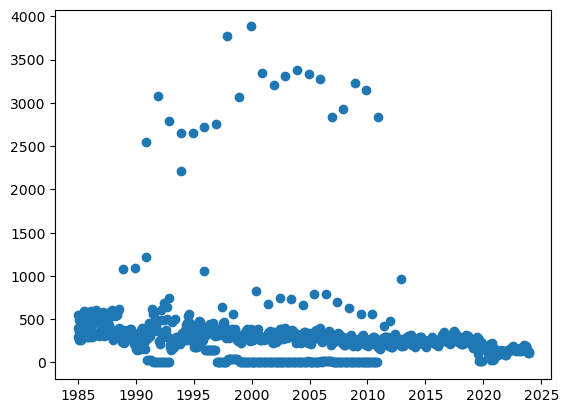

In [16]:
fig, ax = plt.subplots()
ax.scatter(m_combined_data['date'][:1000], m_combined_data['crime_rate'][:1000]);

In [17]:
validate_combined_data(m_combined_data)

C:\Users\marka\AppData\Local\Temp\ipykernel_31628\2961021209.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_counts = df.groupby('state').size()


{'total_states': 52,
 'date_range': (Timestamp('1985-01-01 00:00:00'),
  Timestamp('2024-10-01 00:00:00')),
 'missing_values': {'date': 0, 'crime_rate': 552, 'state': 0},
 'states_missing_data': []}

In [18]:
# Make a copy 
m_combined_data_copy = m_combined_data

In [19]:
m_combined_data.state.value_counts()

state
Alabama               478
Alaska                478
Nevada                478
NewHampshire          478
NewMexico             478
NewYersey             478
NewYork               478
NorthCarolina         478
NorthDakota           478
Ohio                  478
Oklahoma              478
Oregon                478
Pennsylvania          478
RhodeIsland           478
SouthCarolina         478
SouthDakkota          478
Tennessee             478
Texas                 478
US                    478
Utah                  478
Vermont               478
Virginia              478
Washington            478
WestVirginia          478
Wisconsin             478
Nebraska              478
Montana               478
Missouri              478
Idaho                 478
Arizona               478
Arkansas              478
California            478
Colorado              478
Connecticut           478
Delaware              478
DistrictOfColumbia    478
Florida               478
Georgia               478
Hawaii

In [20]:
# Check missing data
m_combined_data.isnull().sum()/len(m_combined_data)

date          0.000000
crime_rate    0.022208
state         0.000000
dtype: float64

## Save preprocessed data 

In [21]:
# Export current tmp dataframe 
m_combined_data.to_csv('raw_combined_state_crime_rates_preprocessed.csv')

In [22]:
# Import preprocessed data
m_combined_data = pd.read_csv('raw_combined_state_crime_rates_preprocessed.csv')
m_combined_data.head()

,Unnamed: 0,date,crime_rate,state
0,0,1985-01-01,296.58,Alabama
1,1,1985-02-01,261.86,Alabama
2,2,1985-03-01,288.37,Alabama
3,3,1985-04-01,265.32,Alabama
4,4,1985-05-01,281.24,Alabama


In [23]:
# Check missing values by state
missing_by_state = (m_combined_data.groupby('state')
                   .agg({'crime_rate': lambda x: x.isnull().sum()})
                   .rename(columns={'crime_rate': 'missing_values'})
                   .sort_values('missing_values', ascending=False))

print("Number of missing values by state:")
print(missing_by_state[missing_by_state['missing_values'] > 0])

Number of missing values by state:
                    missing_values
state                             
Montana                         33
Kentucky                        19
Nebraska                        10
NewHampshire                    10
NewMexico                       10
NewYersey                       10
NewYork                         10
NorthCarolina                   10
NorthDakota                     10
Ohio                            10
Oklahoma                        10
Oregon                          10
Pennsylvania                    10
RhodeIsland                     10
SouthCarolina                   10
SouthDakkota                    10
Tennessee                       10
Texas                           10
US                              10
Utah                            10
Vermont                         10
Virginia                        10
Washington                      10
WestVirginia                    10
Wisconsin                       10
Nevada              

In [24]:
# Fill missing values with state-specific medians
state_medians = m_combined_data.groupby('state')['crime_rate'].transform('median')
m_combined_data['crime_rate_filled'] = m_combined_data['crime_rate'].fillna(state_medians)

# Verify the fill worked
print("\nMissing values after filling:")
print(m_combined_data['crime_rate_filled'].isnull().sum())


Missing values after filling:
0


In [25]:
m_combined_data.head()

,Unnamed: 0,date,crime_rate,state,crime_rate_filled
0,0,1985-01-01,296.58,Alabama,296.58
1,1,1985-02-01,261.86,Alabama,261.86
2,2,1985-03-01,288.37,Alabama,288.37
3,3,1985-04-01,265.32,Alabama,265.32
4,4,1985-05-01,281.24,Alabama,281.24


In [26]:
# Check missing values by state
missing_by_state = (m_combined_data.groupby('state')
                   .agg({'crime_rate': lambda x: x.isnull().sum()})
                   .rename(columns={'crime_rate': 'missing_values'})
                   .sort_values('missing_values', ascending=False))

print("\nNumber of missing values by state:")
print(missing_by_state[missing_by_state['missing_values'] > 0])

# For states with missing values, let's look at their patterns
states_with_missing = missing_by_state[missing_by_state['missing_values'] > 0].index

for state in states_with_missing:
    state_data = m_combined_data[m_combined_data['state'] == state]
    print(f"\n{state} Statistics:")
    print("Time range:", state_data['date'].min(), "to", state_data['date'].max())
    print("Missing months:", state_data['crime_rate'].isnull().sum())
    print("State median:", state_data['crime_rate'].median())
    print("Missing pattern:")
    print(state_data[state_data['crime_rate'].isnull()][['date', 'crime_rate']].head())


Number of missing values by state:
                    missing_values
state                             
Montana                         33
Kentucky                        19
Nebraska                        10
NewHampshire                    10
NewMexico                       10
NewYersey                       10
NewYork                         10
NorthCarolina                   10
NorthDakota                     10
Ohio                            10
Oklahoma                        10
Oregon                          10
Pennsylvania                    10
RhodeIsland                     10
SouthCarolina                   10
SouthDakkota                    10
Tennessee                       10
Texas                           10
US                              10
Utah                            10
Vermont                         10
Virginia                        10
Washington                      10
WestVirginia                    10
Wisconsin                       10
Nevada             

In [27]:
# Let's look at where these gaps are occurring
def analyze_missing_pattern(df, state_name):
    state_data = df[df['state'] == state_name]
    
    # Ensure dates are datetime objects
    missing_dates = pd.to_datetime(state_data[state_data['crime_rate'].isnull()]['date'])
    missing_dates_sorted = sorted(missing_dates)
    
    # Print raw data for debugging
    print(f"\nFirst few missing dates for {state_name}:")
    for date in missing_dates_sorted[:5]:
        print(f"Date type: {type(date)}, Value: {date}")
    
    return {
        'missing_dates': missing_dates_sorted,
        'total_missing': len(missing_dates),
        'first_missing': missing_dates_sorted[0] if missing_dates_sorted else None,
        'last_missing': missing_dates_sorted[-1] if missing_dates_sorted else None
    }

# Analyze patterns for a few states
states_to_check = ['Montana', 'Kentucky', 'Alabama']  # one from each pattern
for state in states_to_check:
    print(f"\n{state} Missing Data Analysis:")
    pattern = analyze_missing_pattern(m_combined_data, state)
    print(f"Total missing: {pattern['total_missing']}")
    print(f"First missing: {pattern['first_missing']}")
    print(f"Last missing: {pattern['last_missing']}")
    print("\nAll missing dates:")
    for date in pattern['missing_dates']:
        print(date)

# Let's also look at the overall data structure
print("\nDataFrame Info:")
print(m_combined_data.info())
print("\nDate column type:", m_combined_data['date'].dtype)


Montana Missing Data Analysis:

First few missing dates for Montana:
Date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, Value: 1994-01-01 00:00:00
Date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, Value: 1994-02-01 00:00:00
Date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, Value: 1994-03-01 00:00:00
Date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, Value: 1994-04-01 00:00:00
Date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, Value: 1994-05-01 00:00:00
Total missing: 33
First missing: 1994-01-01 00:00:00
Last missing: 2024-10-01 00:00:00

All missing dates:
1994-01-01 00:00:00
1994-02-01 00:00:00
1994-03-01 00:00:00
1994-04-01 00:00:00
1994-05-01 00:00:00
1994-06-01 00:00:00
1994-07-01 00:00:00
1994-08-01 00:00:00
1994-09-01 00:00:00
1994-10-01 00:00:00
1994-11-01 00:00:00
1994-12-01 00:00:00
1996-01-01 00:00:00
1996-02-01 00:00:00
1996-03-01 00:00:00
1996-04-01 00:00:00
1996-05-01 00:00:00
1996-07-01 00:00:00
1996-08-01 00

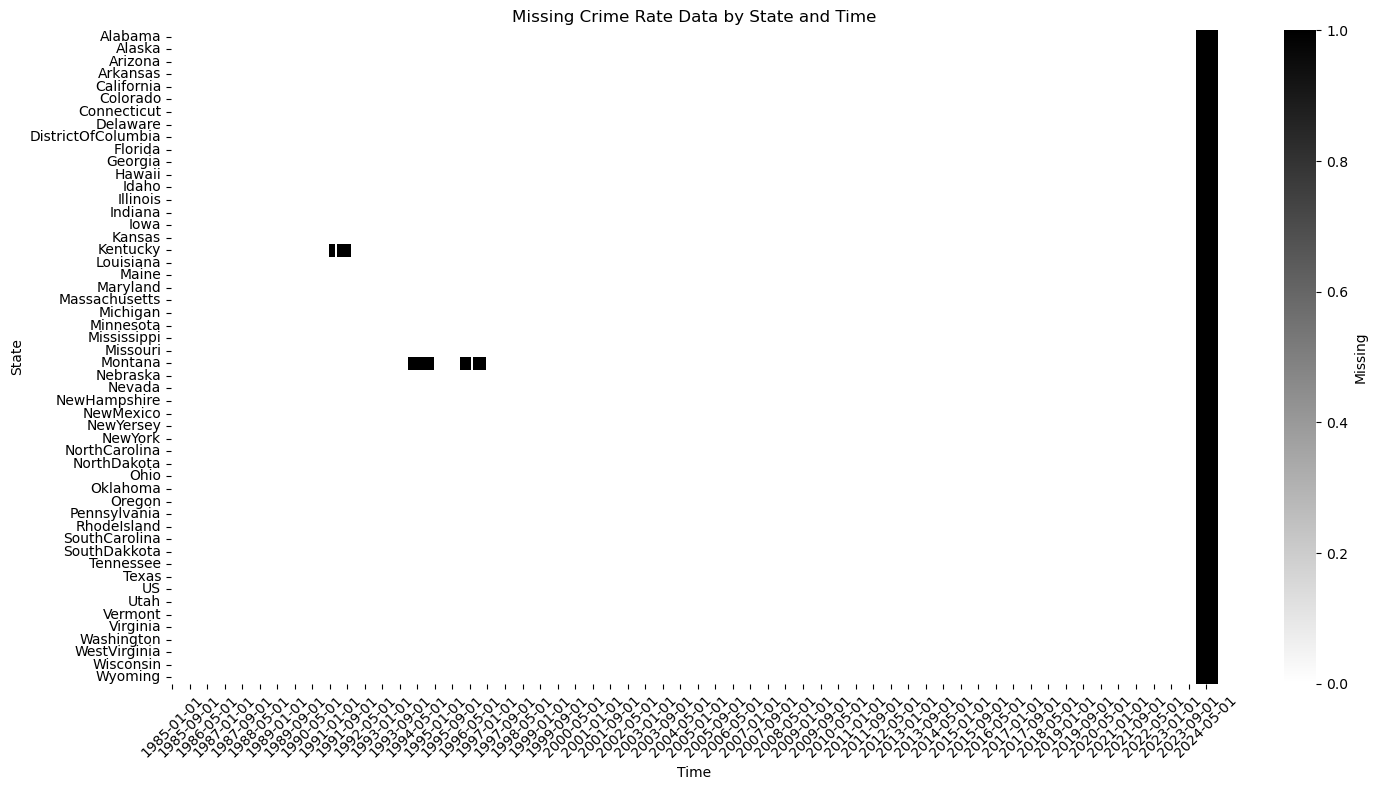

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a visualization of missing data patterns
plt.figure(figsize=(15, 8))

# Create a boolean mask for missing values (True where values are missing)
missing_data = m_combined_data.pivot(index='state', 
                                   columns='date', 
                                   values='crime_rate').isnull()

# Plot heatmap
sns.heatmap(missing_data, 
            cmap='binary',
            cbar_kws={'label': 'Missing'},
            yticklabels=True)

plt.title('Missing Crime Rate Data by State and Time')
plt.xlabel('Time')
plt.ylabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
# Key observations from the output:
print("\nKey Patterns Found:")
print("1. Future Data: All states have missing data for 2024 (Jan-Oct)")
print("2. Historical Gaps:")
print("   - Montana: 1994 (full year) and most of 1996")
print("   - Kentucky: 1991 (Jan-Oct)")
print("3. Missing Data Summary:")
print("   - Most states: 10 months (all in 2024)")
print("   - Kentucky: 19 months (9 in 1991, 10 in 2024)")
print("   - Montana: 33 months (12 in 1994, 11 in 1996, 10 in 2024)")

# Recommendation for filling:
print("\nRecommended Filling Strategy:")
print("1. 2024 Data (All States): Remove these future dates")
print("2. Historical Gaps:")
print("   - Use interpolation for Montana and Kentucky's historical gaps")
print("   - For Montana 1994/1996: Use average of preceding and following years")
print("   - For Kentucky 1991: Use average of surrounding months")


Key Patterns Found:
1. Future Data: All states have missing data for 2024 (Jan-Oct)
2. Historical Gaps:
   - Montana: 1994 (full year) and most of 1996
   - Kentucky: 1991 (Jan-Oct)
3. Missing Data Summary:
   - Most states: 10 months (all in 2024)
   - Kentucky: 19 months (9 in 1991, 10 in 2024)
   - Montana: 33 months (12 in 1994, 11 in 1996, 10 in 2024)

Recommended Filling Strategy:
1. 2024 Data (All States): Remove these future dates
2. Historical Gaps:
   - Use interpolation for Montana and Kentucky's historical gaps
   - For Montana 1994/1996: Use average of preceding and following years
   - For Kentucky 1991: Use average of surrounding months


In [33]:
# 1. First, let's properly convert the date column to datetime
m_combined_data['date'] = pd.to_datetime(m_combined_data['date'])

# 2. Remove 2024 data
m_combined_data_cleaned = m_combined_data[m_combined_data['date'].dt.year < 2024].copy()

In [34]:
# 3. Handle historical gaps using interpolation
# First, let's create a function to interpolate missing values for a specific state
def interpolate_state_data(df, state_name):
    state_data = df[df['state'] == state_name].copy()
    state_data.set_index('date', inplace=True)
    state_data['crime_rate'] = state_data['crime_rate'].interpolate(method='linear')
    return state_data.reset_index()

# Apply interpolation to Montana and Kentucky
montana_fixed = interpolate_state_data(m_combined_data_cleaned, 'Montana')
kentucky_fixed = interpolate_state_data(m_combined_data_cleaned, 'Kentucky')

# Create final cleaned dataset
m_combined_data_cleaned = pd.concat([
    m_combined_data_cleaned[m_combined_data_cleaned['state'] != 'Montana'],
    m_combined_data_cleaned[m_combined_data_cleaned['state'] != 'Kentucky'],
    montana_fixed,
    kentucky_fixed
])

# Sort the data
m_combined_data_cleaned = m_combined_data_cleaned.sort_values(['state', 'date'])

# Verify the cleaning worked
def check_missing_by_state(df):
    missing_by_state = df.groupby('state')['crime_rate'].apply(lambda x: x.isnull().sum())
    return missing_by_state[missing_by_state > 0]

# Check remaining missing values
print("\nMissing values after cleaning:")
print(check_missing_by_state(m_combined_data_cleaned))

# Basic statistics of the cleaned data
print("\nBasic statistics of cleaned crime_rate:")
print(m_combined_data_cleaned['crime_rate'].describe())

# Save the cleaned dataset
m_combined_data_cleaned.to_csv('cleaned_combined_state_crime_rates.csv', index=False)


Missing values after cleaning:
state
Kentucky     9
Montana     23
Name: crime_rate, dtype: int64

Basic statistics of cleaned crime_rate:
count    48640.000000
mean       292.469006
std        194.682333
min          0.000000
25%        195.810000
50%        268.840000
75%        366.790000
max       5914.990000
Name: crime_rate, dtype: float64


In [36]:
len(m_combined_data_cleaned)

48672

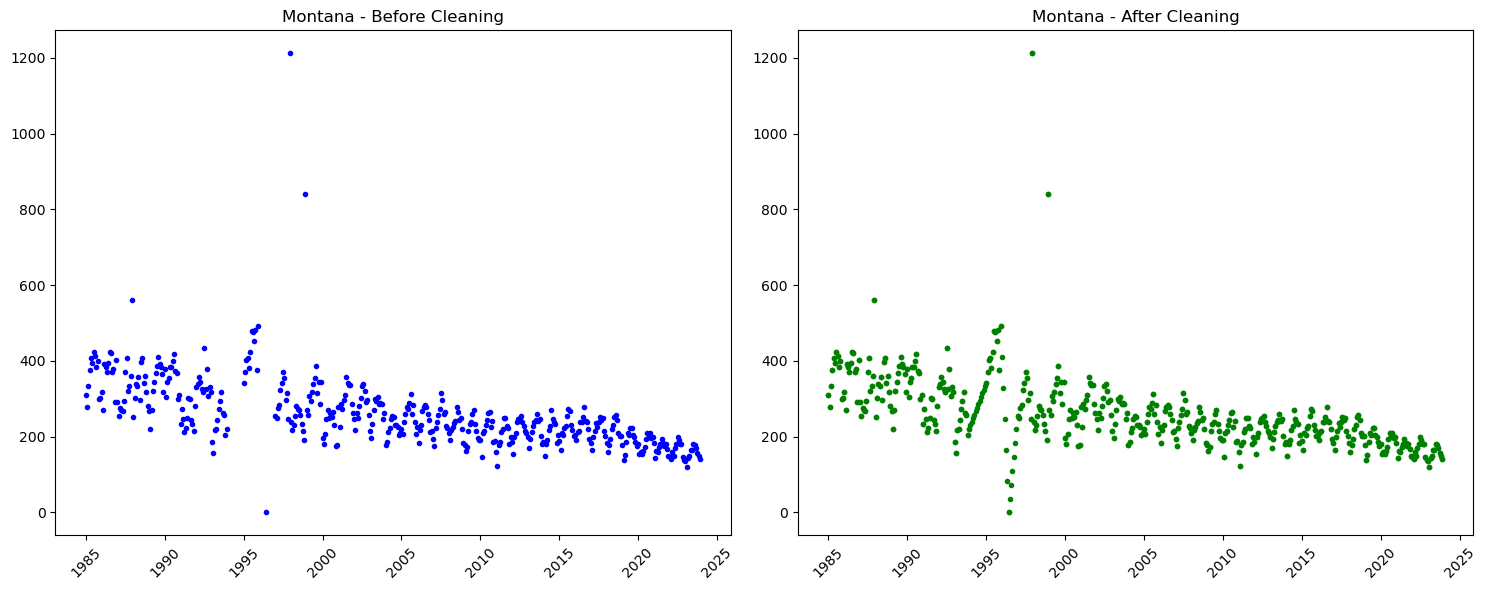

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Montana's data before and after cleaning
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
montana_original = m_combined_data[m_combined_data['state'] == 'Montana']
plt.plot(montana_original['date'], montana_original['crime_rate'], 'b.', label='Original')
plt.title('Montana - Before Cleaning')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
montana_cleaned = m_combined_data_cleaned[m_combined_data_cleaned['state'] == 'Montana']
plt.plot(montana_cleaned['date'], montana_cleaned['crime_rate'], 'g.', label='Cleaned')
plt.title('Montana - After Cleaning')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Checking for duplicate state-date combinations:
No duplicates found


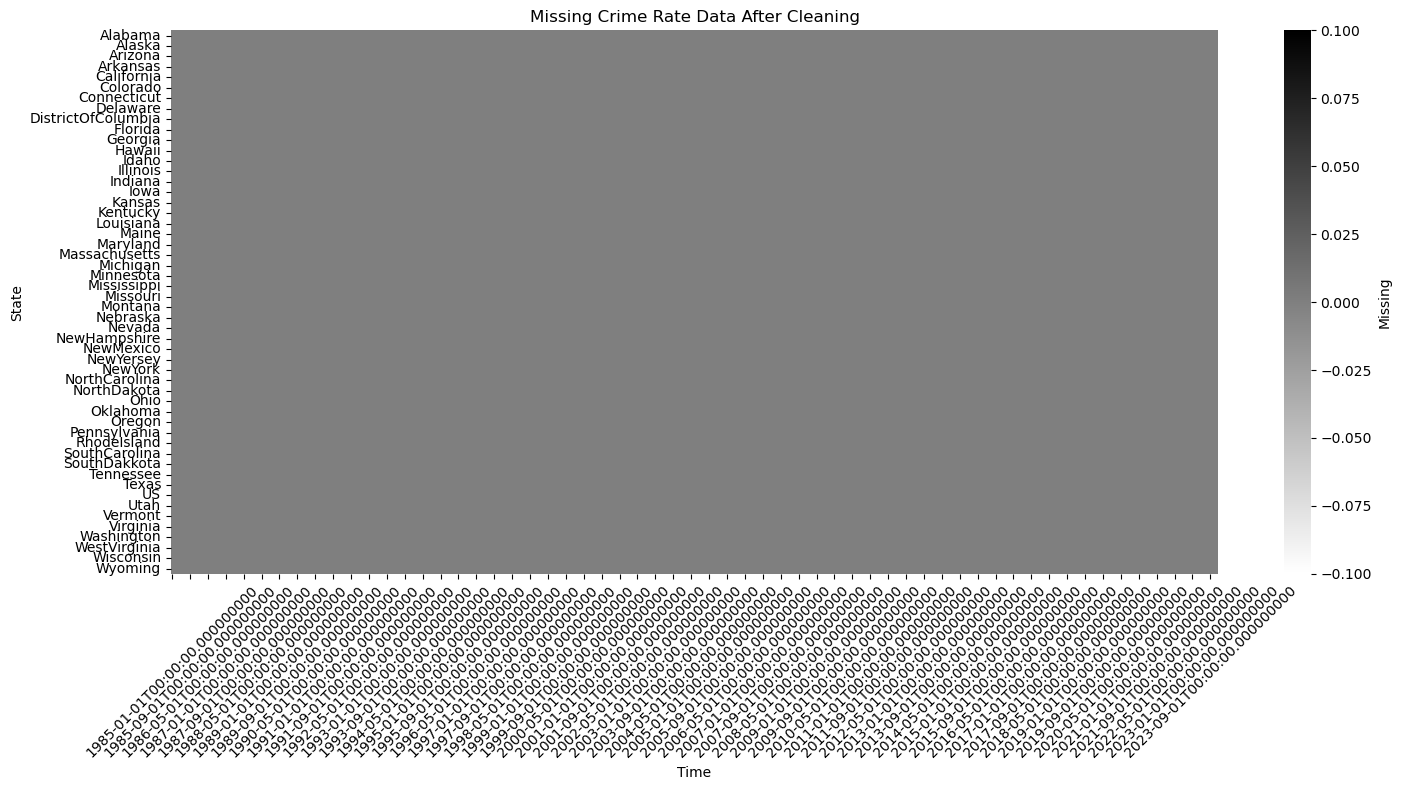


Missing values summary after cleaning:
Total missing values: 0

Missing values by state:
Series([], dtype: int64)


In [42]:
# First, let's check for duplicates
duplicates = m_combined_data_cleaned.groupby(['state', 'date']).size().reset_index(name='count')
duplicates = duplicates[duplicates['count'] > 1]

print("Checking for duplicate state-date combinations:")
print(duplicates if not duplicates.empty else "No duplicates found")

# If there are duplicates, we can handle them by taking the mean value for each state-date combination
m_combined_data_cleaned = m_combined_data_cleaned.groupby(['state', 'date'])['crime_rate'].mean().reset_index()

# Now let's create the heatmap with the deduplicated data
plt.figure(figsize=(15, 8))

# Create pivot table with deduplicated data
pivot_data = m_combined_data_cleaned.pivot(index='state', 
                                         columns='date', 
                                         values='crime_rate')

# Create missing data mask
missing_mask = pivot_data.isnull()

# Create heatmap
sns.heatmap(missing_mask, 
            cmap='binary',
            cbar_kws={'label': 'Missing'},
            yticklabels=True)

plt.title('Missing Crime Rate Data After Cleaning')
plt.xlabel('Time')
plt.ylabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics about missing values
print("\nMissing values summary after cleaning:")
print(f"Total missing values: {missing_mask.sum().sum()}")
print("\nMissing values by state:")
state_missing = missing_mask.sum(axis=1)
print(state_missing[state_missing > 0])

In [46]:
# Detailed look at the duplicates if they exist
if not duplicates.empty:
    print("\nDetailed view of duplicate entries:")
    for _, row in duplicates.iterrows():
        state = row['state']
        date = row['date']
        dups = m_combined_data_cleaned[
            (m_combined_data_cleaned['state'] == state) & 
            (m_combined_data_cleaned['date'] == date)
        ]
        print(f"\nDuplicates for {state} on {date}:")
        print(dups)

In [51]:
def prepare_time_series_data(df, state):
    """
    Prepare time series data for a specific state
    """
    # Filter data for the specific state
    state_data = df[df['state'] == state].copy()
    
    # Print diagnostic information
    print(f"\nInitial data shape for {state}: {state_data.shape}")
    
    # Sort by date
    state_data = state_data.sort_values('date')
    
    # Create time-based features
    state_data['year'] = pd.to_datetime(state_data['date']).dt.year
    state_data['month'] = pd.to_datetime(state_data['date']).dt.month
    state_data['day'] = pd.to_datetime(state_data['date']).dt.day
    
    # Create lagged features (reduce number of lags to prevent data loss)
    for i in range(1, 7):  # Reduced from 12 to 6 months of lag
        state_data[f'lag_{i}'] = state_data['crime_rate'].shift(i)
    
    # Drop rows with NaN values
    state_data = state_data.dropna()
    
    print(f"Data shape after preparation: {state_data.shape}")
    
    # Check if we have enough data
    if len(state_data) < 10:  # Minimum required samples
        raise ValueError(f"Not enough data points for {state} after preparation")
    
    return state_data

In [52]:
def create_and_evaluate_model(df, state_name):
    """
    Create and evaluate time series model for a specific state
    """
    try:
        # Prepare data
        state_data = prepare_time_series_data(df, state_name)
        
        # Separate features and target
        feature_columns = ['year', 'month', 'day'] + [f'lag_{i}' for i in range(1, 7)]
        X = state_data[feature_columns]
        y = state_data['crime_rate']
        
        # Ensure we have enough data
        if len(X) < 10:
            print(f"Not enough data points for {state_name}")
            return None, None
        
        # Split data into train and test sets
        train_size = int(len(state_data) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        print(f"Training set size: {len(X_train)}")
        print(f"Test set size: {len(X_test)}")
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate model
        metrics = evaluate_time_series_model(y_test, y_pred)
        
        # Create visualization
        plt.figure(figsize=(15, 6))
        
        # Plot actual vs predicted values
        plt.subplot(1, 2, 1)
        plt.plot(range(len(y_test)), y_test.values, label='Actual', alpha=0.7)
        plt.plot(range(len(y_pred)), y_pred, label='Predicted', alpha=0.7)
        plt.title(f'Actual vs Predicted Crime Rates - {state_name}')
        plt.legend()
        
        # Plot prediction error distribution
        plt.subplot(1, 2, 2)
        errors = y_test - y_pred
        sns.histplot(errors, kde=True)
        plt.title('Prediction Error Distribution')
        
        plt.tight_layout()
        plt.show()
        
        return metrics, model
    
    except Exception as e:
        print(f"Error processing {state_name}: {str(e)}")
        return None, None


Data points per state:
state
Alabama               468
Alaska                468
Arizona               468
Arkansas              468
California            468
Colorado              468
Connecticut           468
Delaware              468
DistrictOfColumbia    468
Florida               468
Georgia               468
Hawaii                468
Idaho                 468
Illinois              468
Indiana               468
Iowa                  468
Kansas                468
Kentucky              468
Louisiana             468
Maine                 468
Maryland              468
Massachusetts         468
Michigan              468
Minnesota             468
Mississippi           468
Missouri              468
Montana               468
Nebraska              468
Nevada                468
NewHampshire          468
NewMexico             468
NewYersey             468
NewYork               468
NorthCarolina         468
NorthDakota           468
Ohio                  468
Oklahoma              468
Oregon  

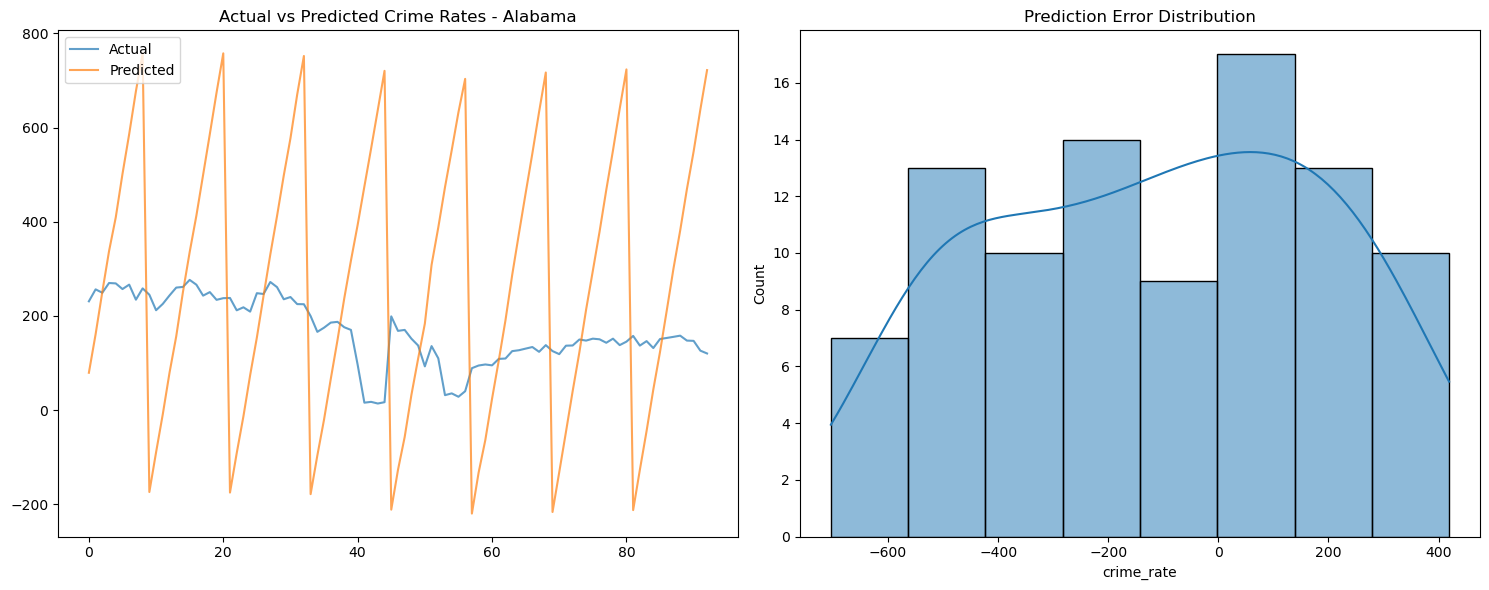


Model Evaluation Metrics:
R² Score: -20.7654
RMSE: 322.95 crime rate units
MAE: 269.10 crime rate units
MAPE: 362.67%
Theil's U: 1.7787

Analyzing Alaska

Initial data shape for Alaska: (468, 3)
Data shape after preparation: (462, 12)
Training set size: 369
Test set size: 93


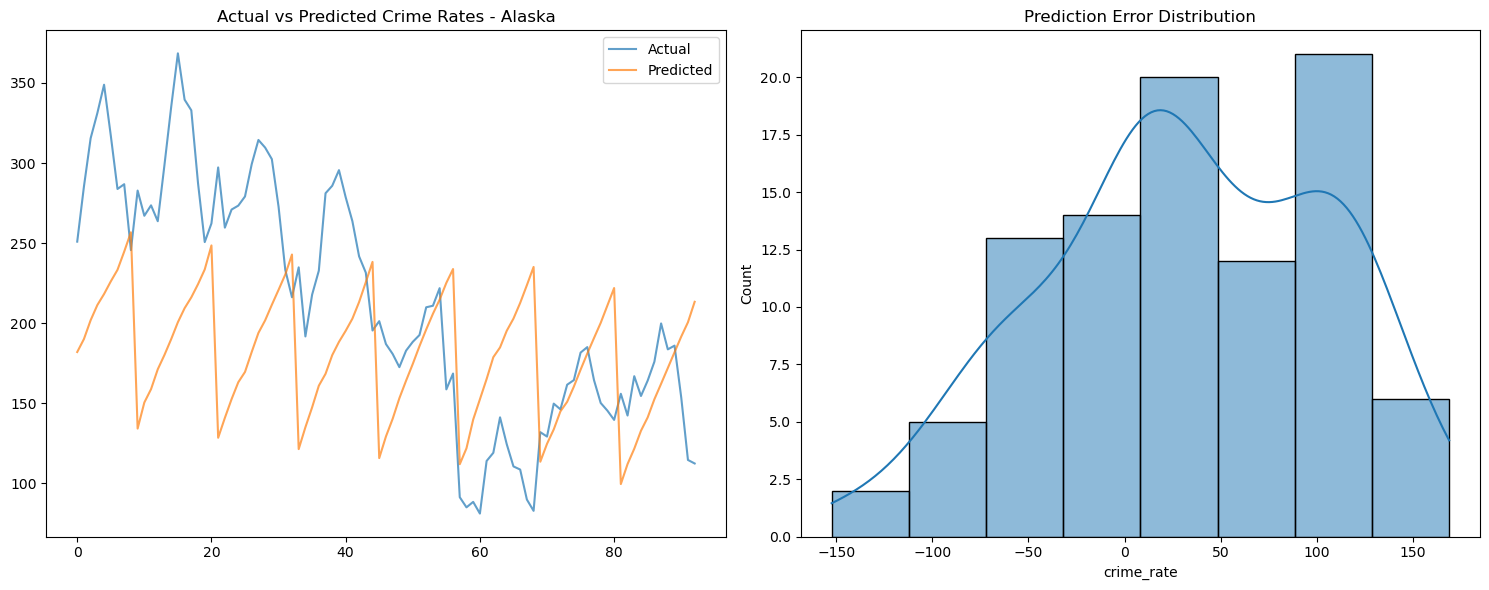


Model Evaluation Metrics:
R² Score: -0.1521
RMSE: 79.18 crime rate units
MAE: 64.89 crime rate units
MAPE: 32.93%
Theil's U: 0.3518

Analyzing Arizona

Initial data shape for Arizona: (468, 3)
Data shape after preparation: (462, 12)
Training set size: 369
Test set size: 93


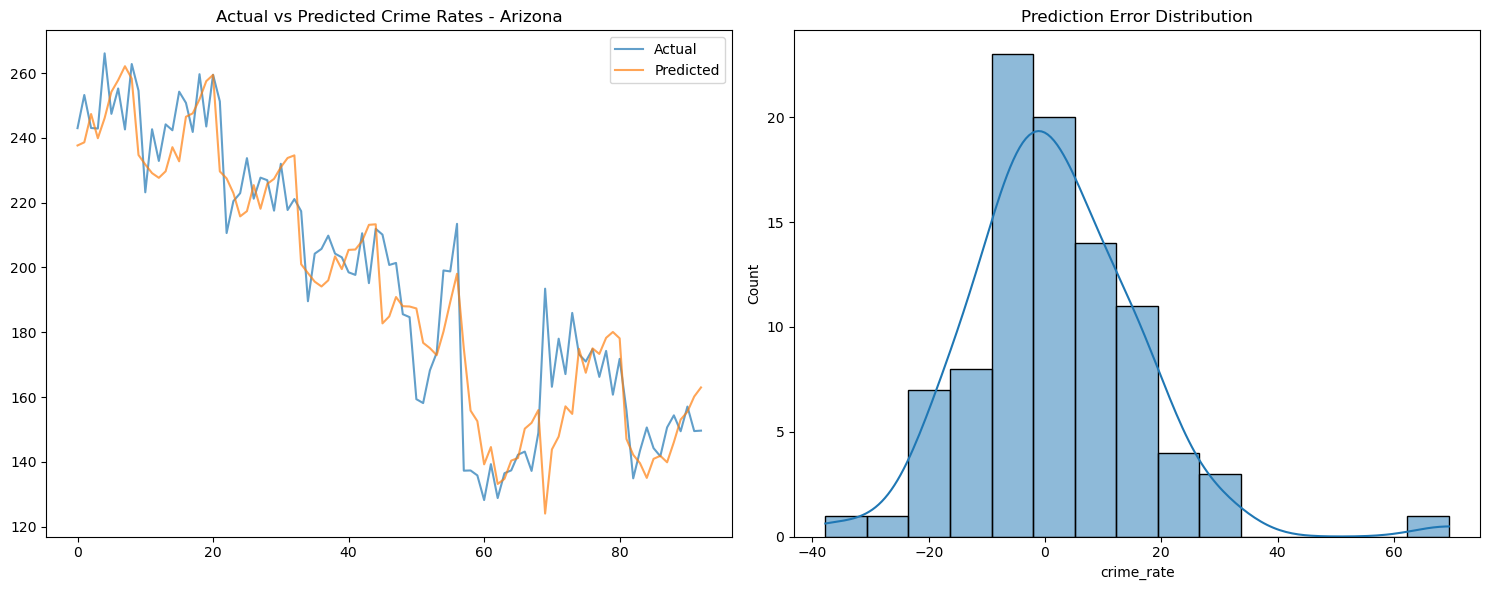


Model Evaluation Metrics:
R² Score: 0.8696
RMSE: 14.61 crime rate units
MAE: 10.72 crime rate units
MAPE: 5.73%
Theil's U: 0.0734

Analyzing Arkansas

Initial data shape for Arkansas: (468, 3)
Data shape after preparation: (462, 12)
Training set size: 369
Test set size: 93


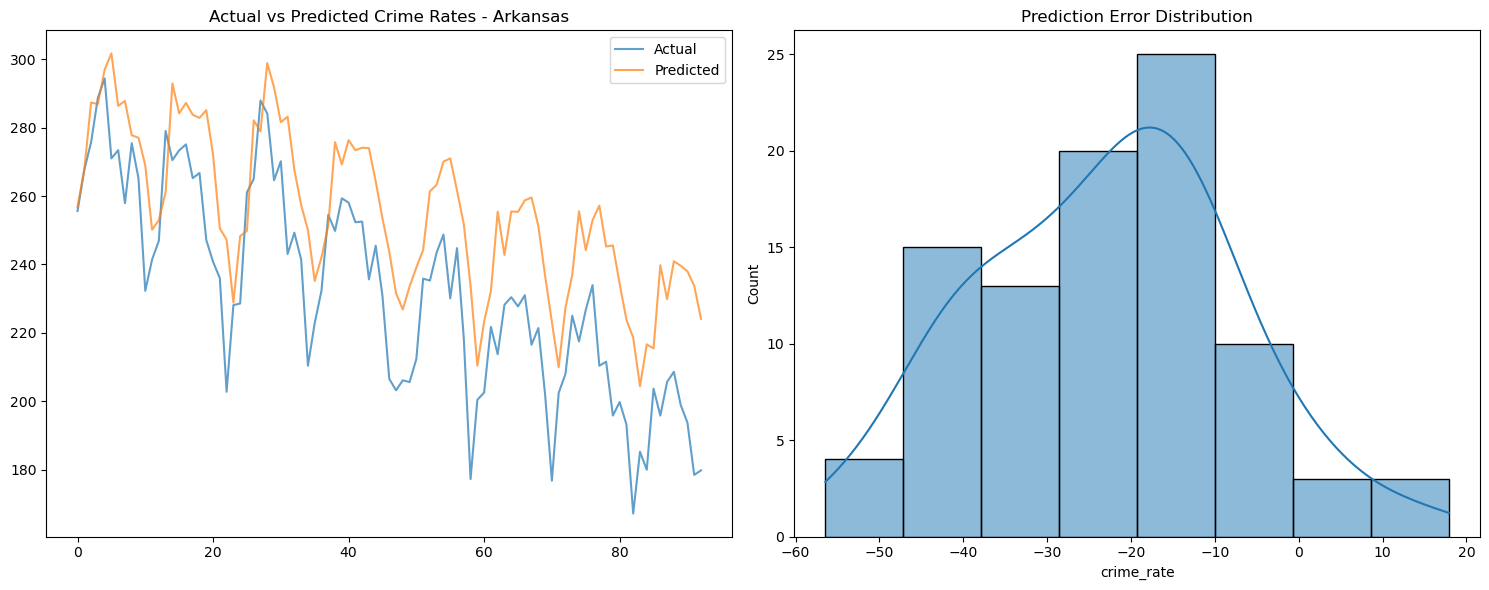


Model Evaluation Metrics:
R² Score: 0.1621
RMSE: 27.53 crime rate units
MAE: 23.84 crime rate units
MAPE: 10.98%
Theil's U: 0.1176


In [54]:
# Let's first check the data availability for each state
def check_data_availability(df):
    state_counts = df.groupby('state').size()
    print("\nData points per state:")
    print(state_counts)
    return state_counts

# Check data availability
state_counts = check_data_availability(m_combined_data_cleaned)

# Choose states with sufficient data
minimum_required_samples = 50  # Adjust this threshold as needed
states_with_sufficient_data = state_counts[state_counts >= minimum_required_samples].index.tolist()

print("\nStates with sufficient data:")
print(states_with_sufficient_data)
print(f'Size = {len(states_with_sufficient_data)}')

# Analyze a few states with sufficient data
states_to_analyze = states_with_sufficient_data[:4]  # Take first 4 states with sufficient data

for state in states_to_analyze:
    print(f"\nAnalyzing {state}")
    metrics, model = create_and_evaluate_model(m_combined_data_cleaned, state)
    if metrics:
        print_metrics(metrics)

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
from datetime import datetime

class ImprovedCrimePredictor:
    def __init__(self):
        self.state_models = {}
        self.preprocessor = None
        self.feature_names = None
        
    def create_features(self, df):
        """Create rich feature set for crime prediction"""
        df = df.copy()
        
        # Temporal features
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['quarter'] = df['date'].dt.quarter
        
        # Cyclical encoding of months
        df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
        df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
        
        # Create lags (3, 6, 12 months)
        for state in df['state'].unique():
            state_mask = df['state'] == state
            for lag in [3, 6, 12]:
                df.loc[state_mask, f'lag_{lag}'] = (
                    df.loc[state_mask, 'crime_rate'].shift(lag)
                )
        
        # Rolling statistics (3, 6, 12 months)
        for state in df['state'].unique():
            state_mask = df['state'] == state
            for window in [3, 6, 12]:
                # Rolling mean
                df.loc[state_mask, f'rolling_mean_{window}'] = (
                    df.loc[state_mask, 'crime_rate']
                    .rolling(window=window, min_periods=1)
                    .mean()
                )
                # Rolling std
                df.loc[state_mask, f'rolling_std_{window}'] = (
                    df.loc[state_mask, 'crime_rate']
                    .rolling(window=window, min_periods=1)
                    .std()
                )
                # Rolling min/max
                df.loc[state_mask, f'rolling_min_{window}'] = (
                    df.loc[state_mask, 'crime_rate']
                    .rolling(window=window, min_periods=1)
                    .min()
                )
                df.loc[state_mask, f'rolling_max_{window}'] = (
                    df.loc[state_mask, 'crime_rate']
                    .rolling(window=window, min_periods=1)
                    .max()
                )
        
        # Year-over-year changes
        for state in df['state'].unique():
            state_mask = df['state'] == state
            df.loc[state_mask, 'yoy_change'] = (
                df.loc[state_mask, 'crime_rate'].pct_change(periods=12)
            )
            
        # Seasonal features
        for state in df['state'].unique():
            state_mask = df['state'] == state
            # Calculate average crime rate by month for each state
            monthly_means = (
                df[state_mask]
                .groupby('month')['crime_rate']
                .transform('mean')
            )
            df.loc[state_mask, 'seasonal_pattern'] = monthly_means
            
        return df
    
    def prepare_data(self, df, state):
        """Prepare data for a specific state"""
        # Filter for state
        state_data = df[df['state'] == state].copy()
        
        # Sort by date
        state_data = state_data.sort_values('date')
        
        # Drop rows with NaN (will be at the start due to lags)
        state_data = state_data.dropna()
        
        # Select features
        feature_cols = [
            'year', 'month', 'quarter',
            'month_sin', 'month_cos',
            'lag_3', 'lag_6', 'lag_12',
            'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12',
            'rolling_std_3', 'rolling_std_6', 'rolling_std_12',
            'rolling_min_3', 'rolling_min_6', 'rolling_min_12',
            'rolling_max_3', 'rolling_max_6', 'rolling_max_12',
            'yoy_change', 'seasonal_pattern'
        ]
        
        X = state_data[feature_cols]
        y = state_data['crime_rate']
        
        return X, y
    
    def train_model(self, X, y):
        """Train an XGBoost model with carefully tuned parameters"""
        model = xgb.XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0.1,
            random_state=42
        )
        
        model.fit(X, y)
        return model
    
    def fit(self, df):
        """Fit models for all states"""
        # Create features
        print("Creating features...")
        df_features = self.create_features(df)
        
        # Train a model for each state
        for state in df['state'].unique():
            if state == 'US':  # Skip national average
                continue
                
            print(f"Training model for {state}...")
            X, y = self.prepare_data(df_features, state)
            
            # Store feature names
            self.feature_names = X.columns
            
            # Create and train model
            model = self.train_model(X, y)
            
            # Store model
            self.state_models[state] = {
                'model': model,
                'scaler': StandardScaler().fit(X)
            }
            
            # Calculate and print metrics
            y_pred = model.predict(X)
            r2 = r2_score(y, y_pred)
            rmse = np.sqrt(mean_squared_error(y, y_pred))
            mae = mean_absolute_error(y, y_pred)
            
            print(f"{state} - R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")
            
            # Print feature importance
            importance = dict(zip(X.columns, model.feature_importances_))
            top_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:5]
            print("Top 5 important features:")
            for feat, imp in top_features:
                print(f"{feat}: {imp:.4f}")
            print()
    
    def predict(self, df, state, date):
        """Make predictions for a specific state and date"""
        if state not in self.state_models:
            raise ValueError(f"No model trained for state: {state}")
            
        # Create features for prediction
        df_features = self.create_features(df)
        
        # Get row for prediction
        pred_row = df_features[
            (df_features['state'] == state) & 
            (df_features['date'] == pd.Timestamp(date))
        ]
        
        if len(pred_row) == 0:
            raise ValueError(f"No data found for state {state} on {date}")
            
        # Extract features
        X = pred_row[self.feature_names]
        
        # Scale features
        X_scaled = self.state_models[state]['scaler'].transform(X)
        
        # Make prediction
        prediction = self.state_models[state]['model'].predict(X_scaled)[0]
        
        return prediction

ModuleNotFoundError: No module named 'xgboost'